In [29]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/bjpw/workspace/mlfs-book
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [30]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [31]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

country="Germany"
city="Berlin"

2025-11-18 18:21:34,658 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 18:21:34,688 INFO: Initializing external client
2025-11-18 18:21:34,689 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 18:21:36,148 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271978


In [32]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality_berlin',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [33]:
selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])
data = selected_features.read()
data.info()

2025-11-18 18:21:38,373 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.01s) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22660 entries, 0 to 22659
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   pm25                         22660 non-null  float32                
 1   date                         22660 non-null  datetime64[us, Etc/UTC]
 2   temperature_2m_mean          22660 non-null  float32                
 3   precipitation_sum            22660 non-null  float32                
 4   wind_speed_10m_max           22660 non-null  float32                
 5   wind_direction_10m_dominant  22660 no

### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [34]:
#feature_view = fs.get_or_create_feature_view(
#    name='air_quality_fv',
#    description="weather features with air quality as the target",
#    version=1,
#    labels=['pm25'],
#    query=selected_features,
#)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [35]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [36]:
#X_train, X_test, y_train, y_test = feature_view.train_test_split(
#    test_start=test_start
#)

In [37]:
from datetime import datetime
import pandas as pd

# Aggregate mean values across all boroughs for each date
df_aggregated = data.groupby('date').agg({
    'pm25': 'mean',
    'temperature_2m_mean': 'mean',
    'precipitation_sum': 'mean',
    'wind_speed_10m_max': 'mean',
    'wind_direction_10m_dominant': 'mean'
}).reset_index()

print(f"Original data shape: {data.shape}")
print(f"Aggregated data shape: {df_aggregated.shape}")
print(f"\nAggregated data info:")
print(df_aggregated.info())
print(f"\nFirst few rows:\n{df_aggregated.head()}")

# Define your test start date
start_date_test_data = "2025-05-01"
test_start = pd.Timestamp(start_date_test_data, tz='UTC')

# Split into train and test based on date
train_df = df_aggregated[df_aggregated['date'] < test_start]
test_df = df_aggregated[df_aggregated['date'] >= test_start]

# Separate features (X) and target (y)
feature_columns = ['temperature_2m_mean', 'precipitation_sum', 
                   'wind_speed_10m_max', 'wind_direction_10m_dominant']

X_train = train_df[feature_columns]
y_train = train_df['pm25']

X_test = test_df[feature_columns]
y_test = test_df['pm25']

# Check the shapes and date ranges
print(f"\n{'='*50}")
print("TRAIN/TEST SPLIT SUMMARY")
print(f"{'='*50}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nTrain date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Test date range: {test_df['date'].min()} to {test_df['date'].max()}")

Original data shape: (22660, 6)
Aggregated data shape: (2168, 6)

Aggregated data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         2168 non-null   datetime64[us, Etc/UTC]
 1   pm25                         2168 non-null   float32                
 2   temperature_2m_mean          2168 non-null   float32                
 3   precipitation_sum            2168 non-null   float32                
 4   wind_speed_10m_max           2168 non-null   float32                
 5   wind_direction_10m_dominant  2168 non-null   float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5)
memory usage: 59.4 KB
None

First few rows:
                       date       pm25  temperature_2m_mean  \
0 2019-12-09 00:00:00+00:00   1.664286             6.660917 

In [38]:
# X_train and X_test already contain only the feature columns
# No need to drop 'date' - it's not there!

print("X_train columns:", X_train.columns.tolist())
print("X_test columns:", X_test.columns.tolist())

# Use them directly
X_features = X_train
X_test_features = X_test

X_train columns: ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
X_test columns: ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']


In [39]:
X_train

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,6.660917,1.2,23.233252,230.857010
1,2.846334,0.1,20.037485,256.544647
2,3.156750,0.9,20.721119,186.983490
3,2.635916,1.3,13.202726,194.888351
4,1.340083,0.0,19.376562,132.988922
...,...,...,...,...
1961,9.746334,0.0,14.330079,72.051552
1962,10.390082,0.0,13.443481,112.067940
1963,11.973415,0.0,8.217153,6.340019
1964,13.681751,0.0,12.730468,309.805511


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [40]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [41]:
# Predicting target values on the test set
#y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
#mse = mean_squared_error(y_test.iloc[:,0], y_pred)
#print("MSE:", mse)

# Calculating R squared using sklearn
#r2 = r2_score(y_test.iloc[:,0], y_pred)
#print("R squared:", r2)

In [42]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test, y_pred)
print("R squared:", r2)

# Optional: Calculate additional metrics
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

MSE: 177.06328
R squared: -0.10127219844976865

Model Performance:
MSE: 177.0633
RMSE: 13.3065
MAE: 5.0772
R²: -0.1013


df columns: ['date', 'pm25', 'predicted_pm25']

df head:
        date       pm25  predicted_pm25
0 2025-05-01  42.672729        6.529443
1 2025-05-02   4.383333        3.639999
2 2025-05-03   2.823334        1.808237
3 2025-05-04   1.470833        3.755006
4 2025-05-05   9.182500       20.465609


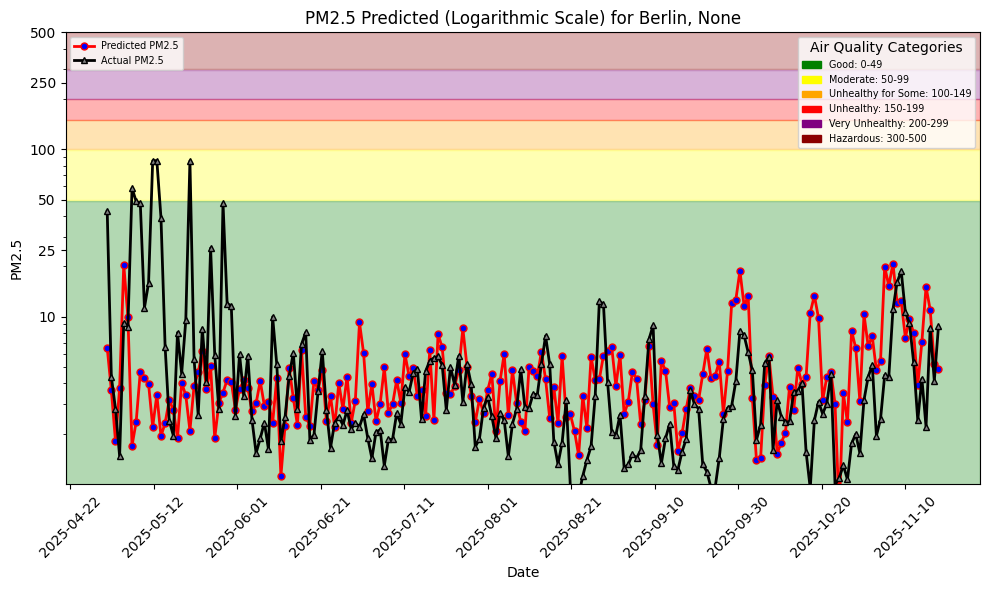

In [43]:
# Recreate y_test to match the other data
y_test = test_df['pm25']

# Create the DataFrame with all required columns
df = pd.DataFrame({
    'date': test_df['date'].values,
    'pm25': y_test.values,
    'predicted_pm25': y_pred
})

df = df.sort_values(by='date')

# Verify the structure
print("df columns:", df.columns.tolist())
print("\ndf head:")
print(df.head())

# Now plot
images_dir = "../../docs/air-quality/assets/img"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)
file_path = images_dir + "/pm25_hindcast_berlin.png"
plt = util.plot_air_quality_forecast(city, None, df, file_path, hindcast=True) 
plt.show()

In [44]:
#df = y_test
#df['predicted_pm25'] = y_pred

In [45]:
#df['date'] = X_test['date']
#df = df.sort_values(by=['date'])
#df.head(5)

In [46]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = "../../docs/air-quality/assets/img"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [47]:
#file_path = images_dir + "/pm25_hindcast.png"
#plt = util.plot_air_quality_forecast(city, None, df, file_path, hindcast=True) 
#plt.show()

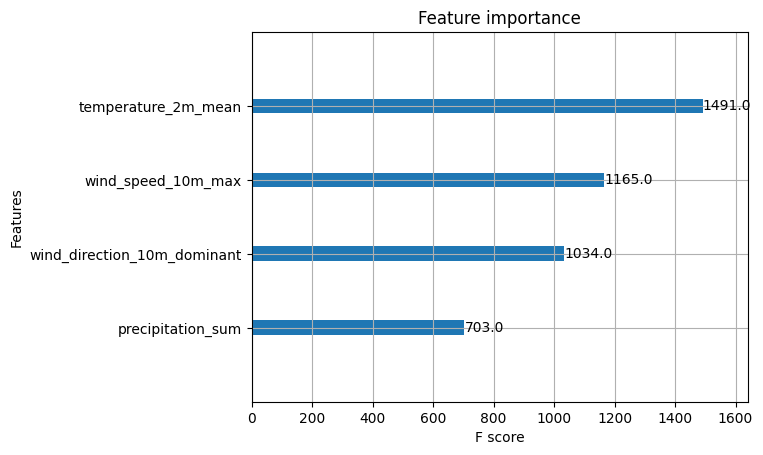

In [54]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/pm25_training_berlin_feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [49]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [50]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [51]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model_berlin", 
    metrics= res_dict,
    #feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
result = aq_model.save(model_dir + "/model.json")
print(result)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/bjpw/workspace/mlfs-book/notebooks/airquality/air_quality_model/model.json: 0.000%|          |…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1271978/models/air_quality_xgboost_model_berlin/4
Model(name: 'air_quality_xgboost_model_berlin', version: 4)


---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
